In [1]:
import datetime as dt
import numpy as np
import os
import pandas as pd
import netCDF4
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
import tensorflow as tf

from netCDF4 import num2date
from astral import LocationInfo
from astral.sun import sun
from functions import *

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def netCDF2df (filename):
    f = netCDF4.Dataset(filename)
    var_names = ['t2m', 'd2m', 'msl', 'tp', 'u10', 'v10', 'u100', 'v100', 'ssrd'] #100m u,v and ssrd data for evalutation
    variables = {key: f.variables[key][:].flatten() for key in var_names} # dictionary of variable name and data, already flattened for pd
    
    # Extract variable - każdy parametr ma przypisane time, lat, lon
    t2m = f.variables['t2m']
    # Get dimensions assuming 3D: time, latitude, longitude
    time_dim, lat_dim, lon_dim = t2m.get_dims()
    time_var = f.variables[time_dim.name]
    times = num2date(time_var[:], time_var.units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
    latitudes = f.variables[lat_dim.name][:]
    longitudes = f.variables[lon_dim.name][:]
    lat, lon = latitudes[0], longitudes[0]
    times_grid, latitudes_grid, longitudes_grid = [x.flatten() for x in np.meshgrid(times, latitudes, longitudes, indexing='ij')]
    
    # additional processing of ssrd data- getting rid of negative values
    ssrd_d = f.variables['ssrd'][:].flatten()
    ssrd_d = np.where(ssrd_d < 10, 0, ssrd_d) / 3600 / 1000 #divide by 3600 s so [J/m2]-->[W/m2], divide by 1000 so finally [kW/m2]
    variables.update({'ssrd' : ssrd_d})
    
    #time variables transformation - rotating vector to u,v components    
    yd_i = [np.sin(t.timetuple()[7]*2*np.pi/year_len(t.year)) for t in times_grid]
    yd_j = [np.cos(t.timetuple()[7]*2*np.pi/year_len(t.year)) for t in times_grid]
    h_i = [np.sin(t.hour*np.pi/12) for t in times_grid]
    h_j = [np.cos(t.hour*np.pi/12) for t in times_grid]
    time = {'yday_i': yd_i, 'yday_j' : yd_j, 'hour_i' : h_i, 'hour_j' : h_j}
    
    #final df build
    df = pd.DataFrame({**{
        'Date Time': [t.isoformat() for t in times_grid],
        #'year' : [t.year for t in times_grid], #used for df division
        #'month' : [t.month for t in times_grid], #used for df trim when full_year = False
        #'yday' : [t.timetuple()[7] for t in times_grid],
        #'hour' : [t.hour for t in times_grid],
        #'dorn' : [day_or_night(t,lat,lon) for t in times_grid],
        #**time,
        **variables
        }})
    f.close()
    return df

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
years = range(1950,2021)
files = ['./data/ERA5/dane_[50,20]_12m_'+str(year)+'.nc' for year in years]
df = pd.DataFrame()
for file in files:
    df = df.append(netCDF2df(file),ignore_index=True)

In [5]:
df.head()

,Date Time,t2m,d2m,msl,tp,u10,v10,u100,v100,ssrd
0,1950-01-01T00:00:00,262.714033,259.900872,103298.015394,NaN,0.637819,-2.406421,0.903655,-3.709255,0.0
1,1950-01-01T01:00:00,260.695745,258.184905,103401.866726,NaN,0.922727,-1.589199,1.500161,-3.410746,0.0
2,1950-01-01T02:00:00,260.195929,257.699157,103434.928307,NaN,1.599350,-2.048641,1.843544,-3.019235,0.0
3,1950-01-01T03:00:00,259.350219,256.948053,103418.318422,NaN,1.825593,-1.757785,2.032306,-2.403842,0.0
4,1950-01-01T04:00:00,258.763065,256.665744,103419.030274,NaN,1.989750,-1.709849,2.543653,-2.705351,0.0


In [6]:
date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

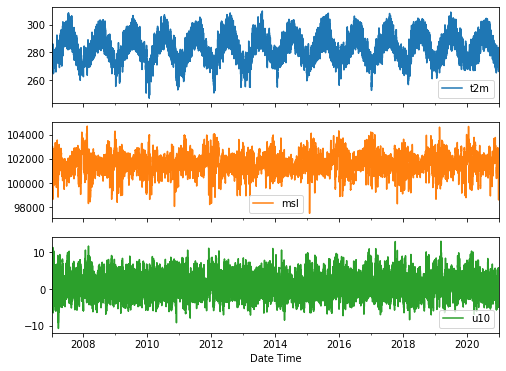

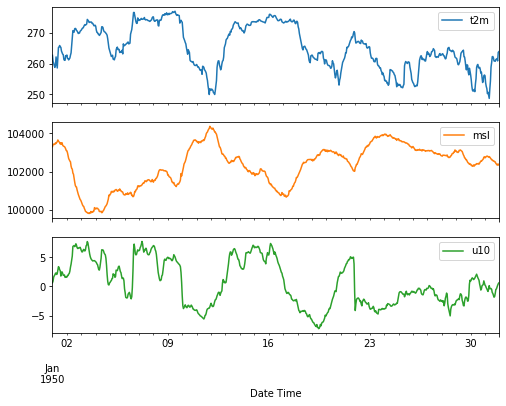

In [7]:
plot_cols = ['t2m', 'msl', 'u10']
plot_features = df[plot_cols][500000:]
plot_features.index = date_time[500000:]
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:744]
plot_features.index = date_time[:744]
_ = plot_features.plot(subplots=True)

Text(0, 0.5, 'Wind Y [m/s]')

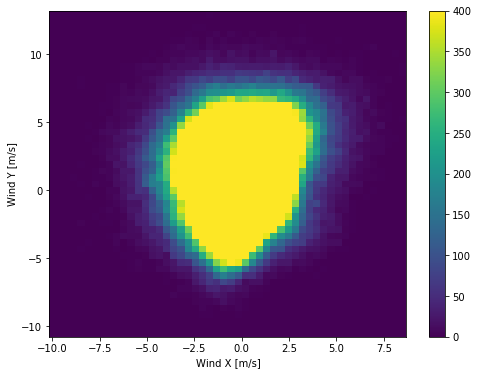

In [8]:
plt.hist2d(df['v10'], df['u10'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')

Missing values:

In [9]:
df.isnull().sum()

t2m      0
d2m      0
msl      0
tp      14
u10      0
v10      0
u100     0
v100     0
ssrd     0
dtype: int64

In [10]:
df['tp'] = df['tp'].fillna(0)
# df['tp'] = df['tp'].fillna(df['tp'].median())

Datetime to signal:

In [11]:
def datetime_to_seconds(dates):
    return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

timestamp_s = date_time.map(datetime_to_seconds)

In [12]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

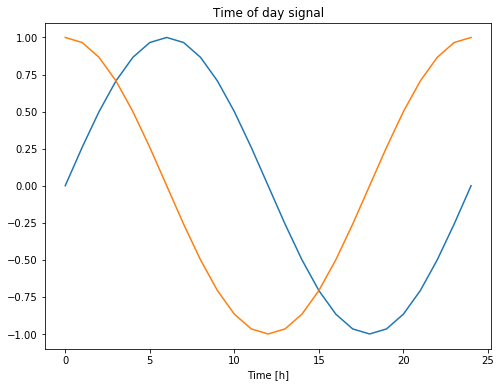

In [13]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Podział danych (70%, 20%, 10%):

In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Normalizacja danych:

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Podział danych na okna:

In [16]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [17]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Rysowanie wykresu dla okna:

In [18]:
def plot(self, model=None, plot_col='u10', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Zmiana DataFrame na tf.data.Dataset:

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Funkcja trenująca:

In [21]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Model Single step

In [22]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['u10'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['u10']

In [23]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['u10'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['u10']

Linear model (dla porównania)

In [24]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [25]:
history = compile_and_fit(linear, single_step_window)

val_performance = {}
performance = {}
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
13615/13615 [==============================] - 79s 6ms/step - loss: 0.1459 - mean_absolute_error: 0.1903 - val_loss: 0.0257 - val_mean_absolute_error: 0.1145
Epoch 2/20
13615/13615 [==============================] - 75s 6ms/step - loss: 0.0242 - mean_absolute_error: 0.1113 - val_loss: 0.0256 - val_mean_absolute_error: 0.1143
Epoch 3/20
13615/13615 [==============================] - 75s 6ms/step - loss: 0.0242 - mean_absolute_error: 0.1113 - val_loss: 0.0257 - val_mean_absolute_error: 0.1144
Epoch 4/20
3890/3890 [==============================] - 14s 4ms/step - loss: 0.0256 - mean_absolute_error: 0.1146


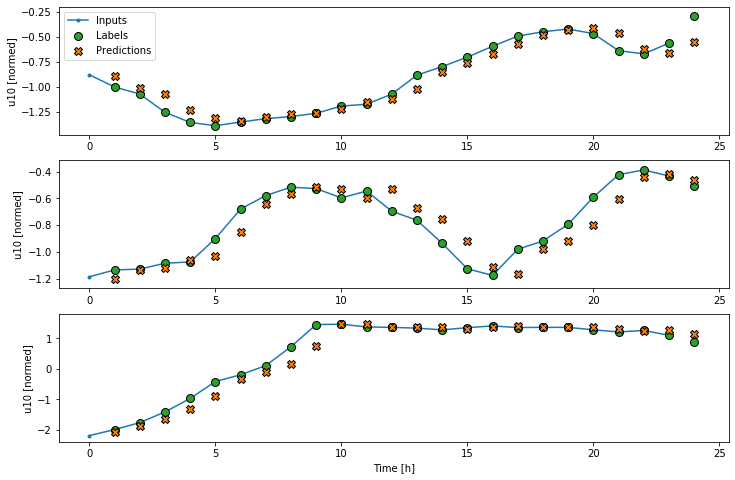

In [26]:
wide_window.plot(linear)

In [27]:
val_performance['Linear'][1]

0.1145753413438797

Funkcja rysująca wagi:

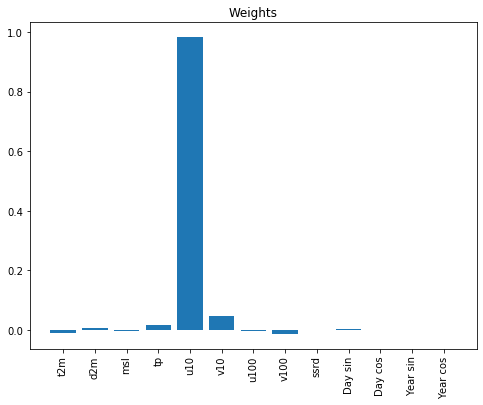

In [28]:
def plot_weights(model, train_df = train_df, layer = 0):
    plt.bar(x = range(len(train_df.columns)),
            height=model.layers[layer].kernel[:,0].numpy())
    axis = plt.gca()
    axis.set_xticks(range(len(train_df.columns)))
    _ = axis.set_xticklabels(train_df.columns, rotation=90)
    plt.title('Weights')

plot_weights(linear)

Sieć głęboka:

In [29]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
13615/13615 [==============================] - 115s 8ms/step - loss: 0.0239 - mean_absolute_error: 0.1107 - val_loss: 0.0232 - val_mean_absolute_error: 0.1095
Epoch 2/20
13615/13615 [==============================] - 116s 9ms/step - loss: 0.0212 - mean_absolute_error: 0.1046 - val_loss: 0.0224 - val_mean_absolute_error: 0.1067
Epoch 3/20
13615/13615 [==============================] - 113s 8ms/step - loss: 0.0208 - mean_absolute_error: 0.1035 - val_loss: 0.0222 - val_mean_absolute_error: 0.1062
Epoch 4/20
13615/13615 [==============================] - 113s 8ms/step - loss: 0.0205 - mean_absolute_error: 0.1027 - val_loss: 0.0220 - val_mean_absolute_error: 0.1053
Epoch 5/20
13615/13615 [==============================] - 115s 8ms/step - loss: 0.0204 - mean_absolute_error: 0.1022 - val_loss: 0.0218 - val_mean_absolute_error: 0.1047
Epoch 6/20
13615/13615 [==============================] - 115s 8ms/step - loss: 0.0202 - mean_absolute_error: 0.1018 - val_loss: 0.0219 - val_mean_abs

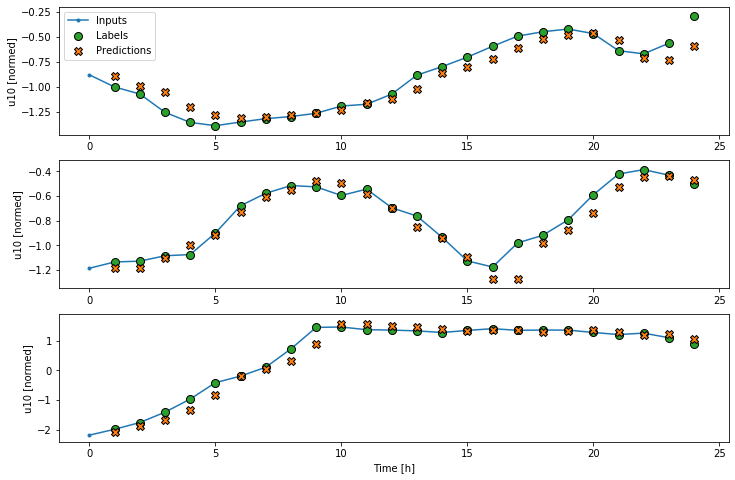

In [30]:
wide_window.plot(dense)

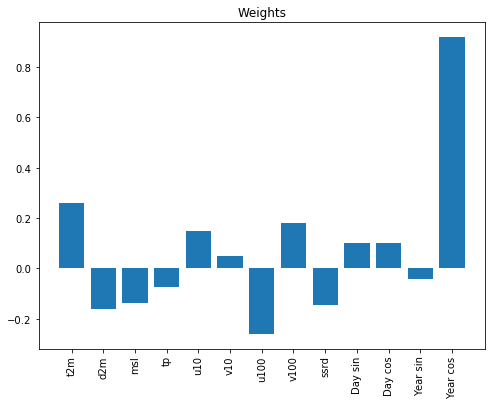

In [31]:
plot_weights(dense)

LSTM

In [32]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [33]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
13615/13615 [==============================] - 126s 9ms/step - loss: 0.0212 - mean_absolute_error: 0.0965 - val_loss: 0.0167 - val_mean_absolute_error: 0.0901
Epoch 2/20
13615/13615 [==============================] - 127s 9ms/step - loss: 0.0147 - mean_absolute_error: 0.0853 - val_loss: 0.0164 - val_mean_absolute_error: 0.0893
Epoch 3/20
13615/13615 [==============================] - 128s 9ms/step - loss: 0.0143 - mean_absolute_error: 0.0842 - val_loss: 0.0163 - val_mean_absolute_error: 0.0891
Epoch 4/20
13615/13615 [==============================] - 128s 9ms/step - loss: 0.0141 - mean_absolute_error: 0.0836 - val_loss: 0.0161 - val_mean_absolute_error: 0.0884
Epoch 5/20
13615/13615 [==============================] - 127s 9ms/step - loss: 0.0139 - mean_absolute_error: 0.0831 - val_loss: 0.0161 - val_mean_absolute_error: 0.0882
Epoch 6/20
13615/13615 [==============================] - 124s 9ms/step - loss: 0.0138 - mean_absolute_error: 0.0827 - val_loss: 0.0160 - val_mean_abs

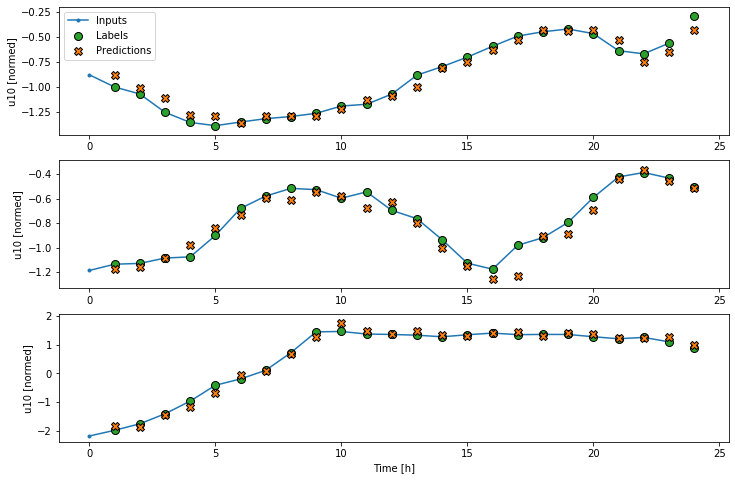

In [34]:
wide_window.plot(lstm_model)

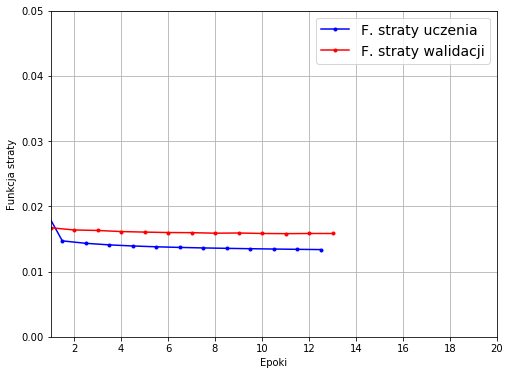

In [44]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="F. straty uczenia")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="F. straty walidacji")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epoki")
    plt.ylabel("Funkcja straty")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

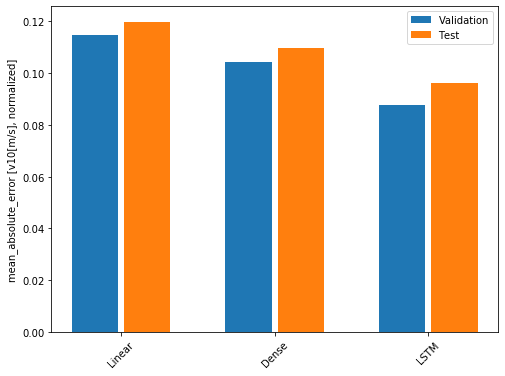

In [45]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [v10[m/s], normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

Zapisanie modeli:

In [46]:
models = [linear, dense, lstm_model]
models_names=['linear', 'dense', 'lstm']
for i, model in enumerate(models):
    model.save('saved_model/'+models_names[i])

INFO:tensorflow:Assets written to: saved_model/linear\assets
INFO:tensorflow:Assets written to: saved_model/dense\assets


INFO:tensorflow:Assets written to: saved_model/lstm\assets


INFO:tensorflow:Assets written to: saved_model/lstm\assets


Multi step models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['u10']

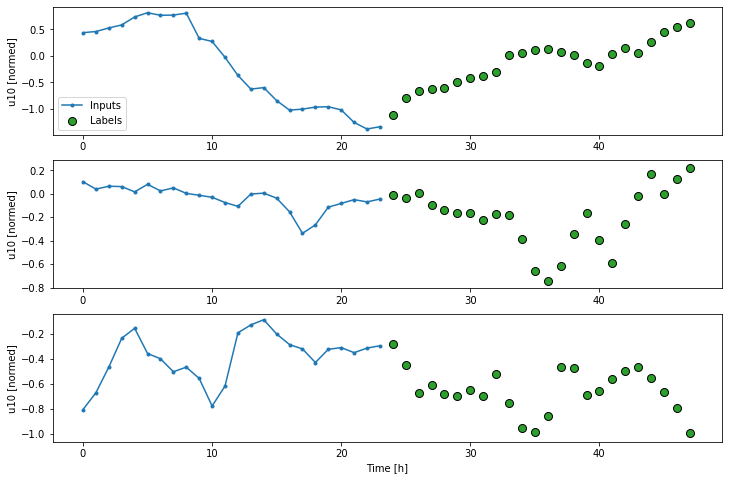

In [71]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['u10'])

multi_window.plot()
multi_window

In [73]:
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', linear(multi_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


3889/3889 [==============================] - 10s 3ms/step - loss: 1.6014 - mean_absolute_error: 0.9839


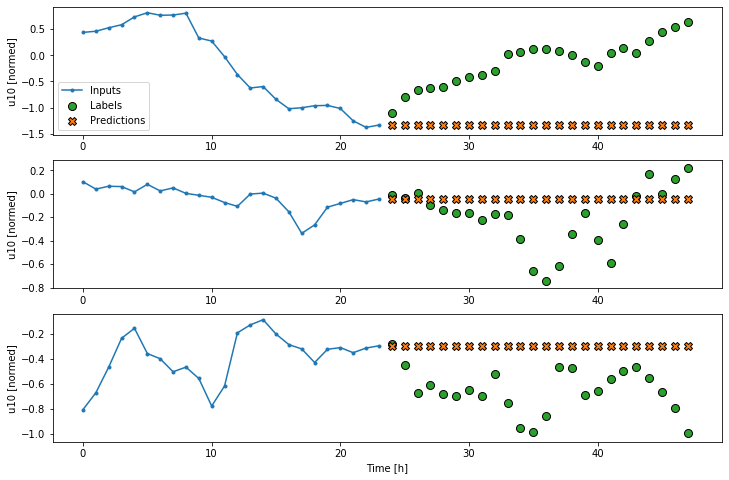

In [83]:
class MultiStepLastBaseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, self.label_index:], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline(label_index=column_indices['u10'])
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

In [78]:
print(last_baseline.label_index)

None


3889/3889 [==============================] - 12s 3ms/step - loss: 1.6621 - mean_absolute_error: 1.0189: 5s  -  - ETA: 0s - loss: 1.6629 - mean_absolute_err


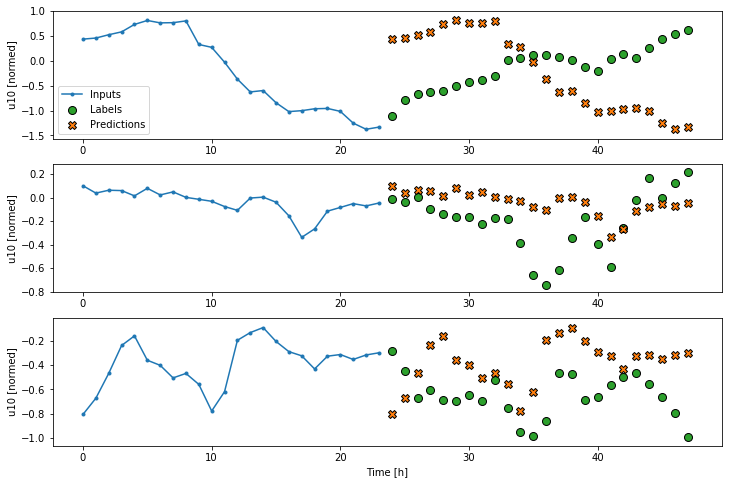

In [85]:
class RepeatBaseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index
  def call(self, inputs):
    return inputs[:,:,self.label_index:]

repeat_baseline = RepeatBaseline(label_index=column_indices['u10'])
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

In [88]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=True),
    # tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.Dense(OUT_STEPS*num_features,
    #                       kernel_initializer=tf.initializers.zeros()),
    # tf.keras.layers.Dense(OUT_STEPS)
                        #   kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    # tf.keras.layers.Reshape([OUT_STEPS, 1])
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(OUT_STEPS))
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/20
13614/13614 [==============================] - 106s 8ms/step - loss: 0.6094 - mean_absolute_error: 0.6138 - val_loss: 0.6034 - val_mean_absolute_error: 0.6127
Epoch 2/20
13614/13614 [==============================] - 106s 8ms/step - loss: 0.5806 - mean_absolute_error: 0.5980 - val_loss: 0.6021 - val_mean_absolute_error: 0.6106
Epoch 3/20
13614/13614 [==============================] - 105s 8ms/step - loss: 0.5700 - mean_absolute_error: 0.5923 - val_loss: 0.6025 - val_mean_absolute_error: 0.6110
Epoch 4/20
3889/3889 [==============================] - 18s 5ms/step - loss: 0.6061 - mean_absolute_error: 0.6113


In [93]:
multi_lstm_model2 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.Dense(OUT_STEPS*num_features,
    #                       kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
    # tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(OUT_STEPS))
])

history = compile_and_fit(multi_lstm_model2, multi_window)

multi_val_performance['LSTM2'] = multi_lstm_model2.evaluate(multi_window.val)
multi_performance['LSTM2'] = multi_lstm_model2.evaluate(multi_window.test, verbose=0)

Epoch 1/20
13614/13614 [==============================] - 104s 8ms/step - loss: 0.3597 - mean_absolute_error: 0.4434 - val_loss: 0.3577 - val_mean_absolute_error: 0.4442
Epoch 2/20
13614/13614 [==============================] - 102s 8ms/step - loss: 0.3365 - mean_absolute_error: 0.4267 - val_loss: 0.3534 - val_mean_absolute_error: 0.4406
Epoch 3/20
13614/13614 [==============================] - 100s 7ms/step - loss: 0.3299 - mean_absolute_error: 0.4223 - val_loss: 0.3541 - val_mean_absolute_error: 0.4404
Epoch 4/20
3889/3889 [==============================] - 17s 4ms/step - loss: 0.3538 - mean_absolute_error: 0.4401


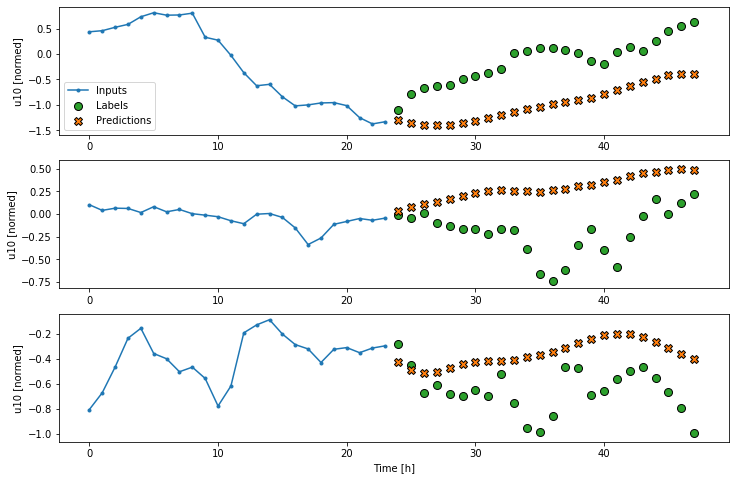

In [95]:
multi_window.plot(multi_lstm_model2)

GRU:

In [99]:
multi_gru_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(32, return_sequences=False),
    # tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_gru_model, multi_window)

multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val)
multi_performance['GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=0)

Epoch 1/20
13614/13614 [==============================] - 96s 7ms/step - loss: 0.3607 - mean_absolute_error: 0.4438 - val_loss: 0.3552 - val_mean_absolute_error: 0.4411
Epoch 2/20
13614/13614 [==============================] - 98s 7ms/step - loss: 0.3387 - mean_absolute_error: 0.4283 - val_loss: 0.3503 - val_mean_absolute_error: 0.4371
Epoch 3/20
13614/13614 [==============================] - 97s 7ms/step - loss: 0.3329 - mean_absolute_error: 0.4245 - val_loss: 0.3490 - val_mean_absolute_error: 0.4364
Epoch 4/20
13614/13614 [==============================] - 100s 7ms/step - loss: 0.3293 - mean_absolute_error: 0.4222 - val_loss: 0.3488 - val_mean_absolute_error: 0.4360
Epoch 5/20
13614/13614 [==============================] - 99s 7ms/step - loss: 0.3266 - mean_absolute_error: 0.4205 - val_loss: 0.3499 - val_mean_absolute_error: 0.4369
Epoch 6/20
3889/3889 [==============================] - 16s 4ms/step - loss: 0.3493 - mean_absolute_error: 0.4367


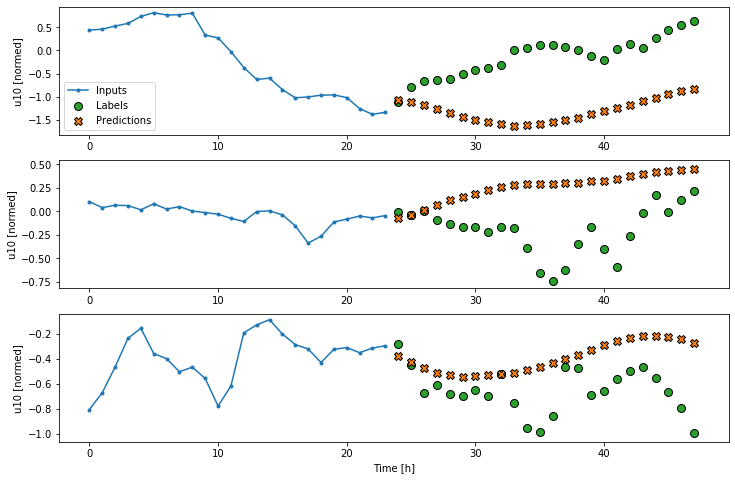

In [101]:
multi_window.plot(multi_gru_model)

Wavenet:

In [106]:
multi_window.example[0].shape

TensorShape([32, 24, 13])

In [109]:
model_wavenet = tf.keras.models.Sequential()
model_wavenet.add(tf.keras.layers.InputLayer(input_shape=[24, 13]))
for rate in (1, 2, 4, 8) * 2:
    model_wavenet.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model_wavenet.add(tf.keras.layers.Conv1D(filters=24, kernel_size=1))


history = compile_and_fit(model_wavenet, multi_window)

multi_val_performance['Wave'] = model_wavenet.evaluate(multi_window.val)
multi_performance['Wave'] = model_wavenet.evaluate(multi_window.test, verbose=0)


Epoch 1/20
13614/13614 [==============================] - 167s 12ms/step - loss: 0.6188 - mean_absolute_error: 0.6192 - val_loss: 0.6151 - val_mean_absolute_error: 0.6178
Epoch 2/20
13614/13614 [==============================] - 171s 13ms/step - loss: 0.5937 - mean_absolute_error: 0.6055 - val_loss: 0.6072 - val_mean_absolute_error: 0.6124
Epoch 3/20
13614/13614 [==============================] - 170s 13ms/step - loss: 0.5857 - mean_absolute_error: 0.6012 - val_loss: 0.6051 - val_mean_absolute_error: 0.6125
Epoch 4/20
13614/13614 [==============================] - 173s 13ms/step - loss: 0.5810 - mean_absolute_error: 0.5988 - val_loss: 0.6022 - val_mean_absolute_error: 0.6119
Epoch 5/20
13614/13614 [==============================] - 172s 13ms/step - loss: 0.5779 - mean_absolute_error: 0.5971 - val_loss: 0.6045 - val_mean_absolute_error: 0.6122
Epoch 6/20
3889/3889 [==============================] - 24s 6ms/step - loss: 0.6037 - mean_absolute_error: 0.6119


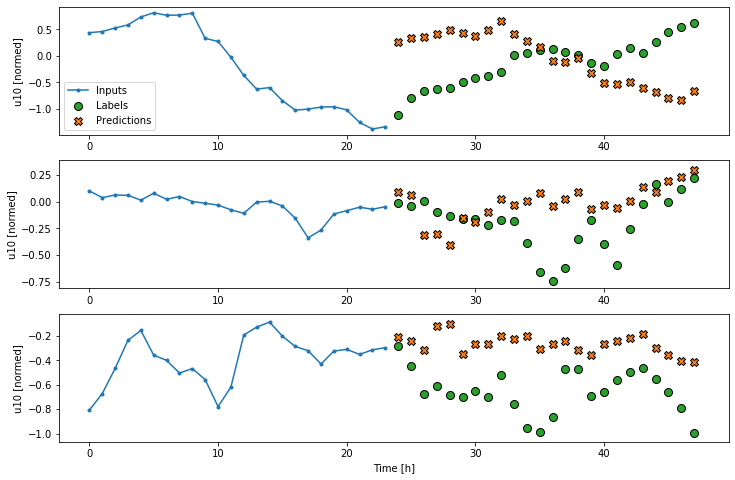

In [111]:
multi_window.plot(model_wavenet)

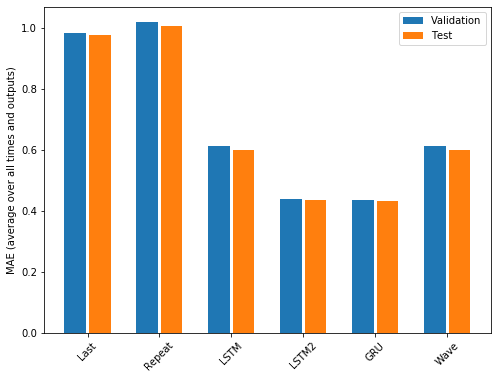

In [110]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [112]:
models = [multi_lstm_model, multi_lstm_model2, multi_gru_model, model_wavenet]
models_names=['multi_lstm_model', 'multi_lstm_model2', 'multi_gru_model', 'model_wavenet']
for i, model in enumerate(models):
    model.save('saved_model/'+models_names[i])


INFO:tensorflow:Assets written to: saved_model/multi_lstm_model\assets


INFO:tensorflow:Assets written to: saved_model/multi_lstm_model\assets


INFO:tensorflow:Assets written to: saved_model/multi_lstm_model2\assets


INFO:tensorflow:Assets written to: saved_model/multi_lstm_model2\assets


INFO:tensorflow:Assets written to: saved_model/multi_gru_model\assets


INFO:tensorflow:Assets written to: saved_model/multi_gru_model\assets


INFO:tensorflow:Assets written to: saved_model/model_wavenet\assets


INFO:tensorflow:Assets written to: saved_model/model_wavenet\assets
